# Text classification with movie reviews

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.

This notebook uses [tf.keras](https://www.tensorflow.org/r1/guide/keras), a high-level API to build and train models in TensorFlow.

In [1]:
import tensorflow.compat.v1 as tf

from tensorflow import keras

import numpy as np

print(tf.__version__)

2.15.0


## Download the IMDB dataset

The IMDB dataset comes packaged with TensorFlow. It has already been preprocessed such that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

The following code downloads the IMDB dataset to your machine (or uses a cached copy if you've already downloaded it):

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


The argument `num_words=10000` keeps the top 10,000 most frequently occurring words in the training data. The rare words are discarded to keep the size of the data manageable.

## Explore the data

Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. Here's what the first review looks like:

In [6]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Movie reviews may be different lengths. The below code shows the number of words in the first and second reviews. Since inputs to a neural network must be the same length, we'll need to resolve this later.

In [7]:
len(train_data[0]), len(train_data[1])

(218, 189)

### Convert the integers back to words

It may be useful to know how to convert integers back to text. Here, we'll create a helper function to query a dictionary object that contains the integer to string mapping:

In [8]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

In [12]:
# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}

In [18]:
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


reverse_word_index.get(i, '?'):
For each integer i, it retrieves the corresponding word from reverse_word_index.
If i is in reverse_word_index, reverse_word_index[i] returns the corresponding word.
If i is not in reverse_word_index, .get(i, '?') returns '?'. This is a safeguard to handle unknown words or indices that may not be in the reverse index (though ideally all indices should be in reverse_word_index).

In [23]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

Now we can use the `decode_review` function to display the text for the first review:

## Prepare the data

The reviews—the arrays of integers—must be converted to tensors before fed into the neural network. This conversion can be done a couple of ways:

* Convert the arrays into vectors of 0s and 1s indicating word occurrence, similar to a one-hot encoding. For example, the sequence  [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones. Then, make this the first layer in our network—a Dense layer—that can handle floating point vector data. This approach is memory intensive, though, requiring a `num_words * num_reviews` size matrix.

* Alternatively, we can pad the arrays so they all have the same length, then create an integer tensor of shape `max_length * num_reviews`. We can use an embedding layer capable of handling this shape as the first layer in our network.

In this tutorial, we will use the second approach.

If you are unfamiliar with embeddings, see the [embedding guide](../../guide/embedding).

Since the movie reviews must be the same length, we will use the [pad_sequences](https://keras.io/preprocessing/sequence/#pad_sequences) function to standardize the lengths:

In [24]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

Let's look at the length of the examples now:

In [25]:
len(train_data[0]), len(train_data[1])

(256, 256)

And inspect the (now padded) first review:

In [26]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## Build the model

The neural network is created by stacking layers—this requires two main architectural decisions:

* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. Let's build a model for this problem:

In [28]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160289 (626.13 KB)
Trainable params: 160289 (626.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
4. The last layer is densely connected with a single output node. Using the `sigmoid` activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function.

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Configure the model to use an optimizer and a loss function:

In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

## Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a *validation set* by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [30]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In the context of the model.fit() function in Keras, the verbose argument determines how training progress is displayed during the training process. Let's break down what verbose does and how it affects the output:

verbose Argument
The verbose argument in model.fit() accepts integers (0, 1, or 2), specifying the verbosity mode:

verbose=0: Silent mode. No output is shown during training (silent mode).

verbose=1: Progress bar mode. An animated progress bar is shown during training, indicating progress for each epoch.

verbose=2: One line per epoch. In this mode, Keras outputs a line of progress for each epoch, like this: Epoch 1/40 - loss: 0.3542 - accuracy: 0.8468 - val_loss: 0.3157 - val_accuracy: 0.8693.



In [34]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 29ms/step - loss: 0.6916 - acc: 0.6365 - val_loss: 0.6894 - val_acc: 0.7131
Epoch 2/40
30/30 [==============================] - 1s 22ms/step - loss: 0.6852 - acc: 0.6805 - val_loss: 0.6802 - val_acc: 0.7328
Epoch 3/40
30/30 [==============================] - 1s 21ms/step - loss: 0.6708 - acc: 0.7437 - val_loss: 0.6620 - val_acc: 0.7571
Epoch 4/40
30/30 [==============================] - 1s 22ms/step - loss: 0.6453 - acc: 0.7660 - val_loss: 0.6327 - val_acc: 0.7716
Epoch 5/40
30/30 [==============================] - 1s 22ms/step - loss: 0.6084 - acc: 0.7919 - val_loss: 0.5944 - val_acc: 0.7929
Epoch 6/40
30/30 [==============================] - 1s 22ms/step - loss: 0.5624 - acc: 0.8181 - val_loss: 0.5497 - val_acc: 0.8116
Epoch 7/40
30/30 [==============================] - 1s 22ms/step - loss: 0.5127 - acc: 0.8357 - val_loss: 0.5047 - val_acc: 0.8247
Epoch 8/40
30/30 [==============================] - 1s 23ms/step - loss: 0.4640 - a

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [35]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 1s - loss: 0.3417 - acc: 0.8714 - 1s/epoch - 2ms/step
[0.3417048752307892, 0.871399998664856]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

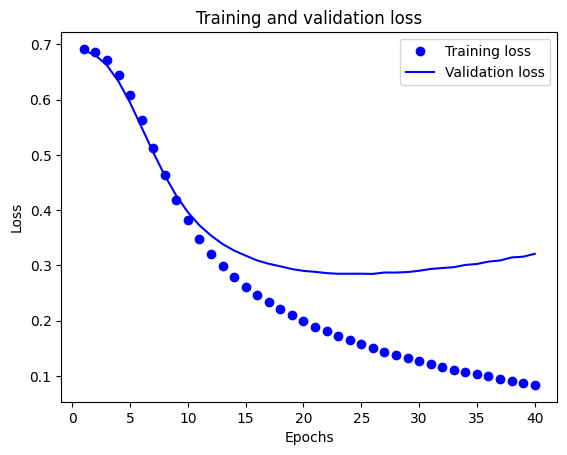

In [37]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

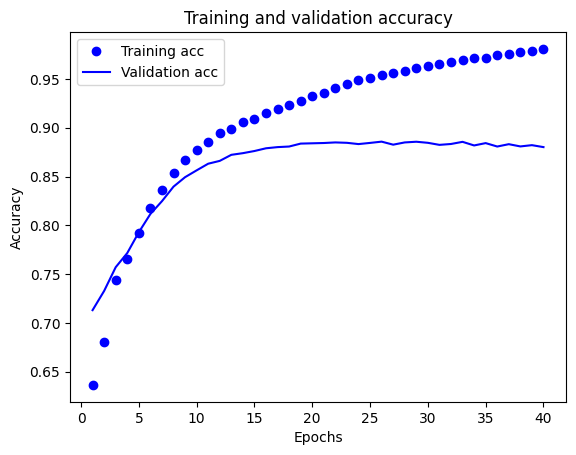

In [38]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. It can be done automatically with a callback.